<a href="https://colab.research.google.com/github/djagatiya/Text2SQL/blob/main/Git_Text2SQL_DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install libraries

In [2]:
!pip install -q -U datasets huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00


### Imports

In [1]:
from datasets import Dataset, load_dataset

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


### Load Dataset

In [2]:
# load dataset and remove unwanted columns
dataset = load_dataset("gretelai/synthetic_text_to_sql") \
    .remove_columns(['domain_description', 'sql_complexity_description',
                     'sql_task_type_description', 'sql_explanation', 'sql_task_type'])

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 5851
    })
})

In [3]:
dataset['train'][0]

{'id': 5097,
 'domain': 'forestry',
 'sql_complexity': 'single join',
 'sql_prompt': 'What is the total volume of timber sold by each salesperson, sorted by salesperson?',
 'sql_context': "CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT); INSERT INTO salesperson (salesperson_id, name, region) VALUES (1, 'John Doe', 'North'), (2, 'Jane Smith', 'South'); CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE); INSERT INTO timber_sales (sales_id, salesperson_id, volume, sale_date) VALUES (1, 1, 120, '2021-01-01'), (2, 1, 150, '2021-02-01'), (3, 2, 180, '2021-01-01');",
 'sql': 'SELECT salesperson_id, name, SUM(volume) as total_volume FROM timber_sales JOIN salesperson ON timber_sales.salesperson_id = salesperson.salesperson_id GROUP BY salesperson_id, name ORDER BY total_volume DESC;'}

In [4]:
import sqlite3

def check_all_tables_have_values(row, debug=False):

    # table must have records
    if row['sql_context'].find('INSERT INTO') == -1:
        return False

    try:
        db = sqlite3.connect(":memory:")
        cur = db.cursor()
        cur.executescript(row['sql_context'])
        res = cur.execute(row['sql']).fetchall()
        if debug: print(res)
        # print(res, len(res))
        return len(res) > 0
    except:
        # print("Error while run query")
        return False

dataset = dataset.filter(lambda x : check_all_tables_have_values(x))
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 53478
    })
    test: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 3133
    })
})

In [5]:
SELECTED_SQL_COMPLEXITY = ['basic SQL', 'aggregation','single join']

SELECTED_DOMAINS = [
    "technology", "sports", "logistics", "space", "energy",
    "finance", "agriculture", "justice", "retail", "media",
    "education", "healthcare", "fashion", "music"
]

def filter_by_sql_task_type_and_domains(row):
    return row['sql_complexity'] in SELECTED_SQL_COMPLEXITY \
         and row['domain'] in SELECTED_DOMAINS

dataset = dataset.filter(lambda x : filter_by_sql_task_type_and_domains(x))
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 6713
    })
    test: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 408
    })
})

In [6]:
train_ds, test_ds = dataset['train'], dataset['test']

In [7]:
train_ds[0]

{'id': 5131,
 'domain': 'healthcare',
 'sql_complexity': 'basic SQL',
 'sql_prompt': 'What is the minimum cultural competency score by worker?',
 'sql_context': 'CREATE TABLE worker_scores (worker_id INT, score INT); INSERT INTO worker_scores (worker_id, score) VALUES (1, 95), (2, 88), (3, 72);',
 'sql': 'SELECT worker_id, MIN(score) FROM worker_scores;'}

#### Data Visualization

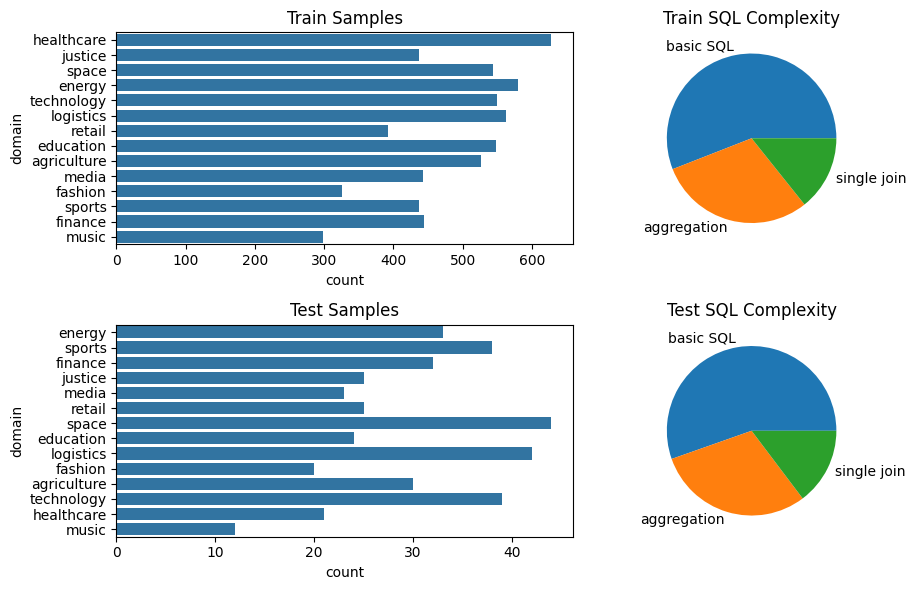

In [8]:
train_df = pd.DataFrame(train_ds)
test_df = pd.DataFrame(test_ds)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

sns.countplot(data=train_df, y='domain', ax=ax[0][0])
ax[0][0].set_title("Train Samples")

sns.countplot(data=test_df, y='domain', ax=ax[1][0])
ax[1][0].set_title("Test Samples")

ax[0][1].set_title("Train SQL Complexity")
ax[0][1].pie(
    x=train_df['sql_complexity'].value_counts(),
    labels=train_df['sql_complexity'].value_counts().index)

ax[1][1].set_title("Test SQL Complexity")
ax[1][1].pie(
    x=test_df['sql_complexity'].value_counts(),
    labels=test_df['sql_complexity'].value_counts().index)

fig.tight_layout()
plt.show()

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 6713
    })
    test: Dataset({
        features: ['id', 'domain', 'sql_complexity', 'sql_prompt', 'sql_context', 'sql'],
        num_rows: 408
    })
})